In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize

Two advertising channel with their own independent lag structure together contributing to generate the total response. Assume for practicing how sound is our estimator that we observe the decomposed sales. Indeed, in reality something that is impossible.


$$ y_1 = \beta_{01} + \beta_{11} \sum{\lambda_{1,j} x_{1,t-j} + u_{1} }  $$


$$ x_1 = \delta_{02} + \delta_{12} \sum{\lambda_{2,j} x_{2,t-j} + u_{2} }  $$


$$\beta_{01} = 10 , \beta_{11} = 0.8, \lambda_{1} = 0.7$$


$$\delta_{02} = 3, \delta_{12} = 0.2, \lambda_{2} = 0.2$$


$$ \sigma_1= 1 , \sigma_2 = 0.5$$

In [11]:
# create the advertising observations (i.e, x1 and x2)
np.random.seed(10)
x2 = np.random.normal(8,2,100)

In [16]:
x1 = np.zeros(100)  
x2_star = np.zeros(100)
x2_star[0] = x2[0] 
for i in range(len(x2) - 1):
    x2_star[i+1] = x2[i+1] + 0.2*x2_star[i]  
for i in range(len(x1)):
    x1[i] = 3 + 0.2*x2_star[i] + np.random.normal(0,0.5)
y1 = np.zeros(100)   
x1_star = np.zeros(100)
x1_star[0] = x1[0] 
for i in range(len(x1) -1):
    x1_star[i+1] = x1[i+1] + 0.7*x1_star[i] 
for i in range(len(x1)):
    y1[i] = 10 + 0.8*x1_star[i] + np.random.normal(0,1)    


Text(0.5, 1.0, 'Ad stocks of the two advertising variables')

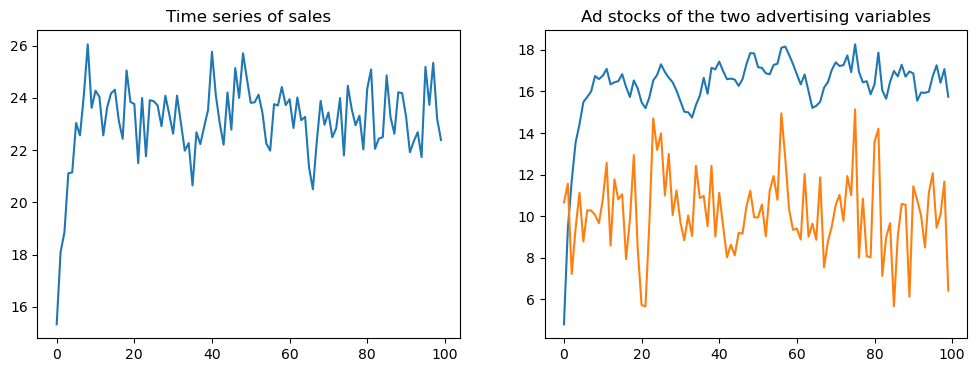

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(np.arange(len(x1)), y1, label='Sales')
axs[0].set_title('Time series of sales')
axs[1].plot(np.arange(len(x1)), x1_star, x2_star, label='Advertising level and Ad stock')
axs[1].set_title('Ad stocks of the two advertising variables')

To estimate we need to write the likelihood with respect to the multivariate vector: $$Y = [y_1,x_1]$$



$$ \ell(\bold{\theta};Y) = -\frac{Tn}{2}\log(2\pi) - \frac{T}{2}\log(|\Sigma|)  - \frac{1}{2} \sum{(Y - \bold{E}(Y))\Sigma^{-1} (Y - \bold{E}(Y))'}  $$


$$ \Sigma = \begin{bmatrix} 
\sigma_{1}^2  &  \sigma_{12} \\
 \sigma_{12} &  \sigma_{2}^2 
\end{bmatrix}
$$


Note that $(Y - \bold{E}(Y))$ is just the error vector $\bold{\epsilon} = [u_1,u_2]$, therefore we can still use the ARMAX inspired estimation technique even in the multivariate case:


$$\bold{\epsilon_1} = [0,0]$$


$$\bold{\epsilon_t} = [u_{1,t},u_{2,t}] = [y_{1,t} - \lambda_1 y_{1,t-1} - \beta_{0,1}^* - \beta_{1,1} x_{1,t} + \lambda_1 u_{1,t} , x_{1,t} - \lambda_2 x_{1,t-1} - \delta_{0,2}^* - \delta_{1,2} x_{2,t} + \lambda_2 u_{2,t}]$$


Finally, the joint likelihood will be found by re_writting the above likelihood as: $n = 2$


$$ \ell(\bold{\theta};Y) = -T \log(2\pi) - \frac{T}{2}\log(|\Sigma|)  - \frac{1}{2} \sum{\bold{\epsilon_t} \Sigma^{-1}\bold{\epsilon_t} '}  $$



In [23]:
def log_likelihood(p,x1,x2,y1):
    b01_hat = p[0]
    b11_hat = p[1]
    b02_hat = p[2]
    b12_hat = p[3]
    lam1_hat = p[4]
    lam2_hat = p[5]
    gam1_hat = p[6]
    gam2_hat = p[7]
    gam12_hat = p[8]
    P  = np.array([[gam1_hat,0], [gam12_hat,gam2_hat]])
    P_T = np.array([[gam1_hat,gam12_hat], [0,gam2_hat]])
    V = np.matmul(P,P_T)
    Det_V = np.linalg.det(V)
    V_inv = np.linalg.inv(V)
    u1 = np.zeros(len(x1))
    u2 = np.zeros(len(x2))
    u1[0] = 0
    u2[0] = 0
    for i in range(len(x1)-1):
        u1[i+1] = y1[i+1] - lam1_hat*y1[i] - b01_hat - b11_hat*x1[i+1] + lam1_hat*u1[i]
        u2[i+1] = x1[i+1] - lam2_hat*x1[i] - b02_hat - b12_hat*x2[i+1] + lam2_hat*u2[i]
    U = np.column_stack((u1,u2))
    L = np.zeros(len(U))
    for i in range (len(U)):
      h_i =   np.matmul(np.matmul(U[i,],V_inv),(U[i,]).reshape(-1,1))
      L[i] = h_i.item()

    l = -(len(U))*np.log(2*np.pi) - 0.5*(len(U))*np.log(Det_V) - 0.5*np.sum(L)
    return -l

In [24]:
#Test the likelihood function:
p0 = [1.5,1,3,0.2, 0.8,0.14,2,4,0.1]
ll = log_likelihood(p0,x1,x2,y1)
ll

1340.0152527233647

In [25]:
minimize(log_likelihood, p0, args= (x1,x2,y1) )

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 197.10973196188286
        x: [ 3.466e+00  6.515e-01  3.171e+00  1.595e-01  7.130e-01
             1.050e-01  9.330e-01  4.505e-01  5.288e-02]
      nit: 35
      jac: [-1.411e-04 -7.019e-04 -5.112e-04 -3.878e-03 -2.750e-03
            -2.697e-03  1.907e-05 -1.907e-04 -6.866e-05]
 hess_inv: [[ 1.269e+00 -1.419e-01 ... -3.107e-03  2.299e-02]
            [-1.419e-01  2.641e-02 ...  6.440e-04 -5.499e-03]
            ...
            [-3.107e-03  6.440e-04 ...  1.002e-03 -1.338e-04]
            [ 2.299e-02 -5.499e-03 ... -1.338e-04  3.352e-03]]
     nfev: 922
     njev: 91